In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use("bioAI.mplstyle")
import torch
import tqdm

import sys
sys.path.append('../')
from models import JacobianCI
from plotting_functions import set_size

In [5]:
color_cycler = plt.rcParams['axes.prop_cycle'].by_key()['color']
savefigs = False
dpi=150

In [6]:
def train_model(model):
    # Train model
    nsamples_space = 2**8
    loss_history = []
    for epoch in tqdm.trange(5000):
        rs = model.unit_cell.sample(nsamples_space)
        rs = torch.tensor(rs,dtype=dtype)
        loss = model.train_step(rs)
        loss_history.append(loss)
    loss_history = np.array(loss_history)
    return loss_history

100%|██████████| 5000/5000 [00:07<00:00, 702.94it/s]


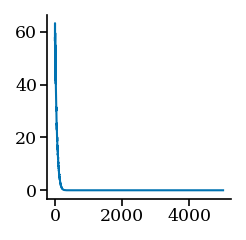

In [9]:
# load trained model
dtype = torch.float32
# choose seed such that metagon is contained in zero-centered unit cell
model = JacobianCI(ncells=7,dtype=dtype,lr=1e-3, shift=0, p_magnitude=0, seed=3)
model_random = JacobianCI(ncells=7,dtype=dtype,lr=1e-3, shift=0, p_magnitude=0, seed=3)
loss_history = train_model(model)

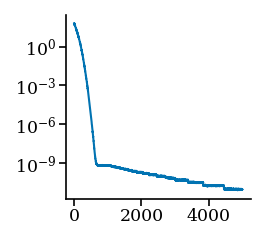

In [11]:
plt.semilogy(loss_history)

Text(0.5, 1.0, 'Activity distance')

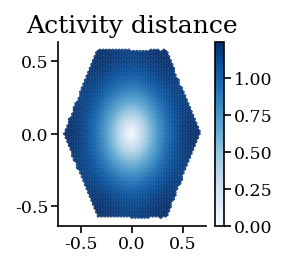

In [103]:
mesh = model.unit_cell.mesh(res:=64)
activity = model(torch.tensor(mesh,dtype=dtype)).detach().numpy()
dists = np.linalg.norm(activity[:,None] - activity[None,:],axis=-1)
plt.scatter(*mesh.T, c=dists[:,0])
plt.colorbar()
plt.title("Activity distance")

Text(0.5, 1.0, 'Activity distance')

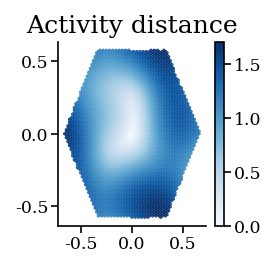

In [104]:
activity_random = model_random(torch.tensor(mesh,dtype=dtype)).detach().numpy()
dists_random = np.linalg.norm(activity_random[:,None] - activity_random[None,:],axis=-1)
plt.scatter(*mesh.T, c=dists_random[:,0])
plt.colorbar()
plt.title("Activity distance")

Text(0.5, 1.0, 'Evaluation points')

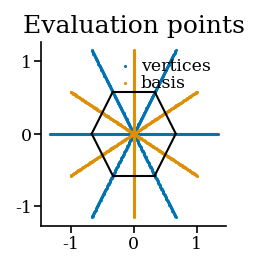

In [109]:
t = np.linspace(0,2,100)
hpoints_interp = model.unit_cell.hpoints * t[:,None,None]
bpoints_interp = model.unit_cell.basis * t[:,None,None]

fig, ax = model.unit_cell.plot(color='k')
ax.scatter(*hpoints_interp.reshape(-1,2).T, label='vertices')
ax.scatter(*bpoints_interp.reshape(-1,2).T, label='basis')
ax.legend()
ax.set_title("Evaluation points")

Text(0.5, 1.0, 'Activity distance 1D')

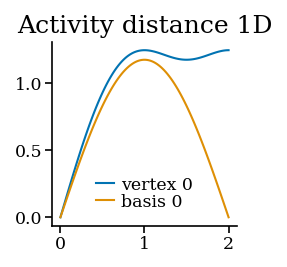

In [110]:
for i in range(1):
    activity = model(torch.tensor(hpoints_interp[:,i],dtype=dtype)).detach().numpy()
    dists = np.linalg.norm(activity - activity[0],axis=-1)
    plt.plot(t,dists, label=f'vertex {i}')
    activity = model(torch.tensor(bpoints_interp[:,i],dtype=dtype)).detach().numpy()
    dists = np.linalg.norm(activity - activity[0],axis=-1)
    plt.plot(t,dists, label=f'basis {i}')
plt.legend()
plt.title("Activity distance 1D")

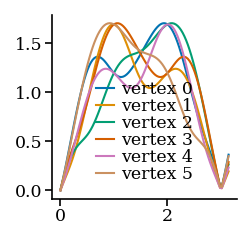

In [107]:
for i in range(6):
    activity = model_random(torch.tensor(hpoints_interp[:,i],dtype=dtype)).detach().numpy()
    dists = np.linalg.norm(activity - activity[0],axis=-1)
    plt.plot(t,dists, label=f'vertex {i}')
    """
    activity = model_random(torch.tensor(bpoints_interp[:,i],dtype=dtype)).detach().numpy()
    dists = np.linalg.norm(activity - activity[0],axis=-1)
    plt.plot(t,dists)
    """
plt.legend()

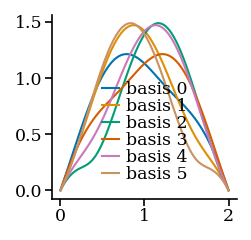

In [112]:
for i in range(6):
    activity = model_random(torch.tensor(bpoints_interp[:,i],dtype=dtype)).detach().numpy()
    dists = np.linalg.norm(activity - activity[0],axis=-1)
    plt.plot(t,dists, label=f'basis {i}')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


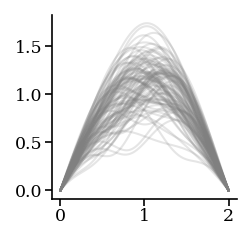

In [117]:
for i in range(100):
    model_random = JacobianCI(ncells=7,dtype=dtype,lr=1e-3, shift=0, p_magnitude=0)#, seed=3)
    activity = model_random(torch.tensor(bpoints_interp[:,0],dtype=dtype)).detach().numpy()
    dists = np.linalg.norm(activity - activity[0],axis=-1)
    plt.plot(t,dists,color='grey',alpha=.2)#, label=f'basis {i}')
plt.legend()

Text(0, 0.5, 'Neural distance')

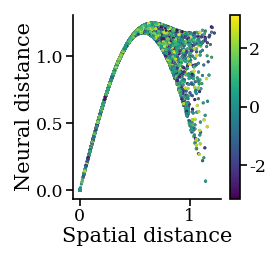

In [200]:
samples = model.unit_cell.sample(100)
activity = model(torch.tensor(samples,dtype=dtype)).detach().numpy()
spatial_dists = np.linalg.norm(samples[:,None] - samples[None,:],axis=-1)
#spatial_angles = np.arctan2(samples[:,None,1], samples[:,None,0])
spatial_angles = np.arctan2(samples[:,None,1] - samples[None,:,1], samples[:,None,0] - samples[None,:,0])
neural_dists = np.linalg.norm(activity[:,None] - activity[None,:],axis=-1)
plt.scatter(spatial_dists.flatten(),neural_dists.flatten(), c=spatial_angles.flatten(), cmap='viridis')
plt.colorbar()
plt.xlabel("Spatial distance")
plt.ylabel("Neural distance")

Text(0, 0.5, 'Neural distance')

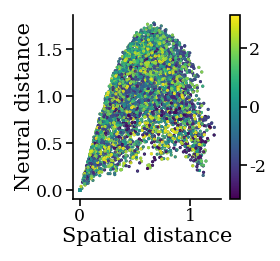

In [199]:
samples = model.unit_cell.sample(100)
activity = model_random(torch.tensor(samples,dtype=dtype)).detach().numpy()
spatial_dists = np.linalg.norm(samples[:,None] - samples[None,:],axis=-1)
#spatial_angles = np.arctan2(samples[:,None,1], samples[:,None,0])
spatial_angles = np.arctan2(samples[:,None,1] - samples[None,:,1], samples[:,None,0] - samples[None,:,0])
neural_dists = np.linalg.norm(activity[:,None] - activity[None,:],axis=-1)
plt.scatter(spatial_dists.flatten(),neural_dists.flatten(), c=spatial_angles.flatten(), cmap='viridis')
plt.colorbar()
plt.xlabel("Spatial distance")
plt.ylabel("Neural distance")

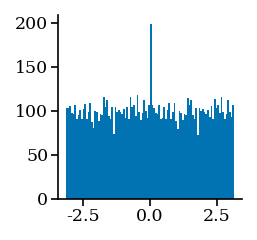

In [190]:
plt.hist(spatial_angles.flatten(), bins=100);